Basic analysis to iHMP_IBDMDB_2019. The overlap (21 metabolites) with OSA. 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessors import MetabolitePreprocessor


Metabolite mapped to HMDB - v. Taxa mapped using GTDB - v.
This research data is HMP2 cohort - longitudinal samples from IBD patient and control.
The metabolom is untargeted. Microbiome is shotgun. 
There are 382 samples for 105 patient. For control we have 104 samples for 26 subjects.
We will take only control and all samples (ignoring longitudinal). 


In [2]:
human_db_path = '/home/noa/lab_code/microbiome-metabolome-curated-data/data/processed_data'
dataset = 'iHMP_IBDMDB_2019'

metadata = pd.read_csv(f'{human_db_path}/{dataset}/metadata.tsv' ,sep='\t')
metabolite = pd.read_csv(f'{human_db_path}/{dataset}/mtb.tsv' ,sep='\t')
metabolite_to_hmdb = pd.read_csv(f'{human_db_path}/{dataset}/mtb.map.tsv' ,sep='\t')
taxa = pd.read_csv(f'{human_db_path}/{dataset}/genera.tsv' ,sep='\t')

In [3]:
metabolite_to_hmdb = metabolite_to_hmdb.set_index('Compound')['HMDB']

Metadata overview: Study.Group:
CD - Crohn's disease
UC - ulcreative colitis. 
nonIBD - control 

In [4]:
# Filter to control samples only:
control_samples_ids = metadata[metadata['Study.Group'] == 'nonIBD'].Sample.unique()
taxa = taxa[taxa.Sample.isin(control_samples_ids)]
metabolite = metabolite[metabolite.Sample.isin(control_samples_ids)]


Taxa is in genus level in relative abundance. 
No need to normalize, but do need to filter rare taxa. 

Filter rare taxa according to the following criteria: we want that the at least 10% of the samples will have relative-abundance larger than 0.001.

In [5]:
# Filter rare taxa (taxa have non-zero values in >10% of the samples)")
# Filter rare taxa according to the following criteria: we want that the at least 10% of the samples will have relative-abundance larger than 0.001.

taxa = taxa.set_index('Sample')
verbose=False
percentage=10
abundance_threshold=0.001
min_number_of_samples = int((taxa.shape[0] / 100) * percentage)
print(
    f"The number of genus/features that have relative abundance values larger then {abundance_threshold} on > {percentage} % samples are: "
    f"{(((taxa > abundance_threshold).sum(axis=0)) >= min_number_of_samples).sum()}"
    f" out of {taxa.shape[1]} genus/features before-filtering.")

non_rare_columns = taxa.columns[
    ((taxa > abundance_threshold).sum(axis=0)) >= min_number_of_samples]
taxa = taxa[non_rare_columns]

The number of genus/features that have relative abundance values larger then 0.001 on > 10 % samples are: 107 out of 9694 genus/features before-filtering.


Load metabolite data.
Map compound to HMDB (article metabolite name in the original data). As it can be many to one, we will sum according to HMDB.
1. Map metabolites compounds to HMDB name convention (Keep only the once we recognize)
2. Sum the abundance of compounds map to the same HMDB metabolite. 

In [6]:
metabolite = metabolite.set_index('Sample')

In [7]:
# metabolite.columns.isin(metabolite_to_hmdb.index).all()
metabolite = metabolite[metabolite.columns.intersection(metabolite_to_hmdb.dropna().index)].rename(columns=metabolite_to_hmdb.dropna())
metabolite = metabolite.groupby(by=metabolite.columns, axis=1).sum()
print(metabolite.shape)
# Rename from HMDB to meangful naming... 
map_hmdb_id_to_name = pd.read_pickle('/home/noa/lab_code/H2Mtranslation/data/map_hmdb_id_to_name.pkl')
hmdb_metadata = pd.read_pickle('/home/noa/lab_code/H2Mtranslation/data/hmdb_name_and_description.pkl')
metabolite = metabolite.rename(columns=map_hmdb_id_to_name)


(104, 454)


Filter rare metabolite

In [8]:
percentage = 85
min_number_of_samples = int((metabolite.shape[0] / 100) * percentage)
print(f"min_number_of_samples: {min_number_of_samples}")
print(f"metabolite shape: {metabolite.shape}")

min_number_of_samples: 88
metabolite shape: (104, 454)


In [9]:
metabolite = metabolite.fillna(0)
non_rare_columns = metabolite.columns[((metabolite.shape[0] - (
            metabolite.round(decimals=8) == 0).sum(axis=0)) >= min_number_of_samples)]
print(f"There are {len(non_rare_columns)} metabolite with sufficient number of samples "
      f"(>{percentage}%) out of {metabolite.shape[1]} metabolites.")
metabolite= metabolite[non_rare_columns]

There are 375 metabolite with sufficient number of samples (>85%) out of 454 metabolites.


Pre-processing metabolite data:

In [10]:
min_value_per_metabolite = metabolite.replace(to_replace=0, value=np.nan).min(axis=0) / 2
metabolite.replace(to_replace=np.nan, value=0, inplace=True)
metabolite.replace(to_replace=0, value=min_value_per_metabolite, inplace=True)
metabolite = metabolite.apply(lambda x: np.log(x + 1))
metabolite.head()


,Deoxycytidine,4-Pyridoxic acid,alpha-Ketoisovaleric acid,p-Hydroxyphenylacetic acid,Ureidopropionic acid,Biotin,Adenine,Taurocholic acid,Butyric acid,Betaine,...,N-Acetylhistidine,HMDB0035665,17-Methyloctadecanoic acid,HMDB0037942,TG(14:0/14:0/16:0),HMDB0042093,HMDB0043058,2-Hydroxyglutarate,HMDB0059824,10Z-Heptadecenoic acid
Sample,,,,,,,,,,,,,,,,,,,,,
HSM5MD5D,12.818366,14.149857,10.236991,10.802408,9.801067,18.017231,14.302072,13.069583,15.220003,11.722051,...,10.983070,8.921725,7.474772,11.372916,8.328209,9.034677,9.106978,11.996672,8.412055,12.759515
MSM6J2K6,15.510480,15.616391,9.592059,11.748164,9.639001,17.552187,15.118838,14.322898,15.558922,13.311884,...,11.961903,8.158516,10.554145,12.910531,7.724005,8.360773,10.696412,12.976577,10.601199,15.023866
HSM5MD6K,15.267840,14.491845,7.985825,11.977470,9.835423,17.051244,14.985529,13.674023,16.236450,13.114035,...,12.452268,10.565273,7.426549,14.486872,6.380123,7.874739,10.091460,11.489984,9.605822,12.312858
MSM6J2HT,16.727060,15.203554,9.617271,13.011155,10.635158,16.334514,14.196841,15.915374,15.786928,13.736330,...,10.711658,7.231287,10.719251,12.291635,2.140066,8.196437,10.134004,12.532018,10.553153,13.993887
MSM6J2JR,14.153341,12.077506,7.546974,11.778416,8.489205,18.341299,13.402568,11.597285,15.355539,13.193619,...,10.173706,8.054205,10.098520,12.539816,15.878592,7.670429,11.928935,11.867189,9.873131,13.960778


Correlation test:
For each metabolite independently, and for each taxa independently, (aka for each (metabolite, genus) tuple) calculate correlation across samples. 

Kendall's tau is preferred over Spearman correlation when: (a) we want robustness to outliers (b) small number of samples (c) many rank ties. 
So I think it may be good for our data. 

In [11]:
# Do we have 'Unknown' in our taxa? no. They drop unknown - is it problematic? As in mice we do have unknown... But it's really different %. 

In [12]:
metabolome_bacteria_corr_coefficient = pd.DataFrame(index=taxa.columns, columns=metabolite.columns)
metabolome_bacteria_p_values = pd.DataFrame(index=taxa.columns, columns=metabolite.columns)

for metabolome in metabolite.columns:
    for bacteria in taxa.columns:
        coefficient, p  = stats.kendalltau(metabolite[metabolome], taxa[bacteria])
        metabolome_bacteria_corr_coefficient.loc[bacteria, metabolome] = coefficient
        metabolome_bacteria_p_values.loc[bacteria, metabolome] = p
        

In [13]:
# With multi-comparison correction (FDR)
# what to do with nans?
p_values = metabolome_bacteria_p_values.stack()
_, p_values_corrected = fdrcorrection(p_values)
metabolome_bacteria_p_values_fdr_correction = pd.Series(p_values_corrected, index=p_values.index).unstack()

In [14]:
metabolome_bacteria_p_values_fdr_correction

,Deoxycytidine,4-Pyridoxic acid,alpha-Ketoisovaleric acid,p-Hydroxyphenylacetic acid,Ureidopropionic acid,Biotin,Adenine,Taurocholic acid,Butyric acid,Betaine,...,N-Acetylhistidine,HMDB0035665,17-Methyloctadecanoic acid,HMDB0037942,TG(14:0/14:0/16:0),HMDB0042093,HMDB0043058,2-Hydroxyglutarate,HMDB0059824,10Z-Heptadecenoic acid
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella,0.907919,0.542831,0.914013,0.012921,0.293948,0.69028,0.319324,0.343756,0.567806,0.286669,...,0.683689,0.055747,0.623478,0.033552,0.654363,0.889895,0.465301,0.649909,0.317055,0.69375
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Acutalibacteraceae;g__CAG-177,0.357703,0.323391,0.967226,0.07648,0.42483,0.659534,0.717074,0.433721,0.874311,0.093377,...,0.92513,0.58536,0.850062,0.112571,0.547257,0.889895,0.383813,0.670373,0.509024,0.947671
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Faecousia,0.276929,0.441636,0.484206,0.00222,0.083159,0.515497,0.914852,0.09501,1.0,0.124822,...,0.709494,0.785143,0.494493,0.147878,0.65173,0.680345,0.086363,0.264812,0.402026,0.395185
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Alloprevotella,0.688299,0.865584,0.93315,0.696279,0.161068,0.777492,0.397244,0.854071,0.662516,0.662516,...,0.429382,0.985803,0.249485,0.23021,0.992121,0.598127,0.307371,0.997158,0.239772,0.020758
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum,0.834606,0.881419,0.827313,0.360345,0.359671,0.687812,0.953973,0.130154,0.813141,0.538537,...,0.946027,0.977682,0.944326,0.578707,0.94916,0.779839,0.939607,0.202551,0.72236,0.431691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Eubacterium_I,0.374254,0.800469,0.819483,0.920131,0.415128,0.916331,0.499646,0.429382,0.879011,0.277432,...,0.681014,0.361869,0.709494,0.839686,0.767113,0.965154,0.888403,0.678556,0.364662,0.484809
d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Veillonellales;f__Megasphaeraceae;g__Megasphaera,0.486909,0.183561,0.764658,0.61616,0.769996,0.762845,0.253255,0.839686,0.923614,0.163105,...,0.937349,0.876079,0.275753,0.370686,0.912257,0.86718,0.959622,0.931322,0.337803,0.177386
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,0.177957,0.497278,0.453099,0.623478,0.51315,0.156125,0.022285,0.923614,0.206551,0.281328,...,0.309356,0.351081,0.435841,0.292498,0.750623,0.961312,0.740647,0.467727,0.386178,0.542831
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__CAG-103,0.213344,0.493846,0.542831,0.001282,0.40892,0.258243,0.953505,0.009549,0.967226,0.312682,...,0.926765,0.54547,0.99863,0.682965,0.652513,0.355622,0.13223,0.742487,0.240912,0.522832


In [15]:
metabolome_bacteria_corr_coefficient = metabolome_bacteria_corr_coefficient.T.stack()
metabolome_bacteria_p_values_fdr_correction = metabolome_bacteria_p_values_fdr_correction.T.stack()

In [16]:
metabolome_bacteria_significant_corr = metabolome_bacteria_corr_coefficient[metabolome_bacteria_p_values_fdr_correction < 0.05]

In [17]:
print(f"There are {metabolome_bacteria_significant_corr.shape[0]} significant couples out of {metabolome_bacteria_corr_coefficient.shape[0]} "
      f" ({taxa.shape[1]} genus, {metabolite.shape[1]} metabolome) "
      f"after FDR correction (aka {round(100 * metabolome_bacteria_significant_corr.shape[0]/ metabolome_bacteria_corr_coefficient.shape[0] ,2)} %.)")

There are 2570 significant couples out of 40125  (107 genus, 375 metabolome) after FDR correction (aka 6.4 %.)


In [18]:
metabolome_bacteria_significant_corr.sort_values(ascending=False)


L-Alanine               d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium    0.370052
L-Serine                d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium    0.356236
Urobilin                d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Christensenellales;f__CAG-74;g__Ventricola                0.355709
L-Glutamine             d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium    0.352875
Methionine sulfoxide    d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium    0.348614
                                                                                                                                 ...   
Palmitoylcarnitine      d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Acutalibacteraceae;g__CAG-177         -0.385801
7-Methylguanine         d__Bacteria;p__Firmicute

In [19]:
# metabolome_bacteria_significant_corr.to_pickle(f'{dataset}/metabolome_bacteria_significant_corr_kendall-tau.pkl')
# metabolome_bacteria_corr_coefficient.to_pickle(f'{dataset}/metabolome_bacteria_corr_coefficient_kendall-tau.pkl')
# metabolome_bacteria_p_values_fdr_correction.to_pickle(f'{dataset}/metabolome_bacteria_p_values_fdr_correction_kendall-tau.pkl')

In [20]:
taxa_rename_to_genus = pd.Series(metabolome_bacteria_significant_corr.index.get_level_values(1), index=metabolome_bacteria_significant_corr.index.get_level_values(1)).str.extract('.*g__(.*)').squeeze()

In [21]:
metabolome_bacteria_significant_corr = metabolome_bacteria_significant_corr.rename(taxa_rename_to_genus.to_dict(), axis=0, level=1)

In [22]:
metabolome_bacteria_significant_corr.head()

Deoxycytidine  Scatosoma     -0.222061
               Alistipes_A   -0.223075
               Alistipes     -0.214515
               Coproplasma    -0.24494
               Akkermansia   -0.213382
dtype: object

<Axes: title={'center': 'L-Alanine'}>

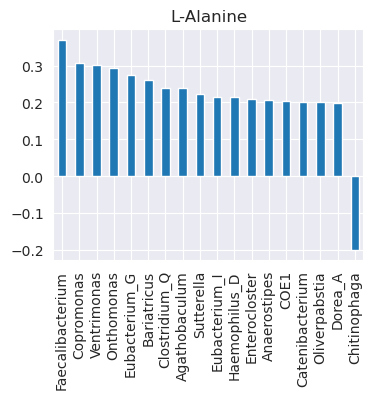

In [23]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

top_metabolite = metabolome_bacteria_significant_corr.sort_values(ascending=False).index[0][0]
idx = pd.IndexSlice
metabolome_bacteria_significant_corr.loc[idx[top_metabolite, :]].sort_values(ascending=False).plot.bar(figsize=(4,3), title=top_metabolite)

<Axes: title={'center': 'Linoleoyl ethanolamide'}>

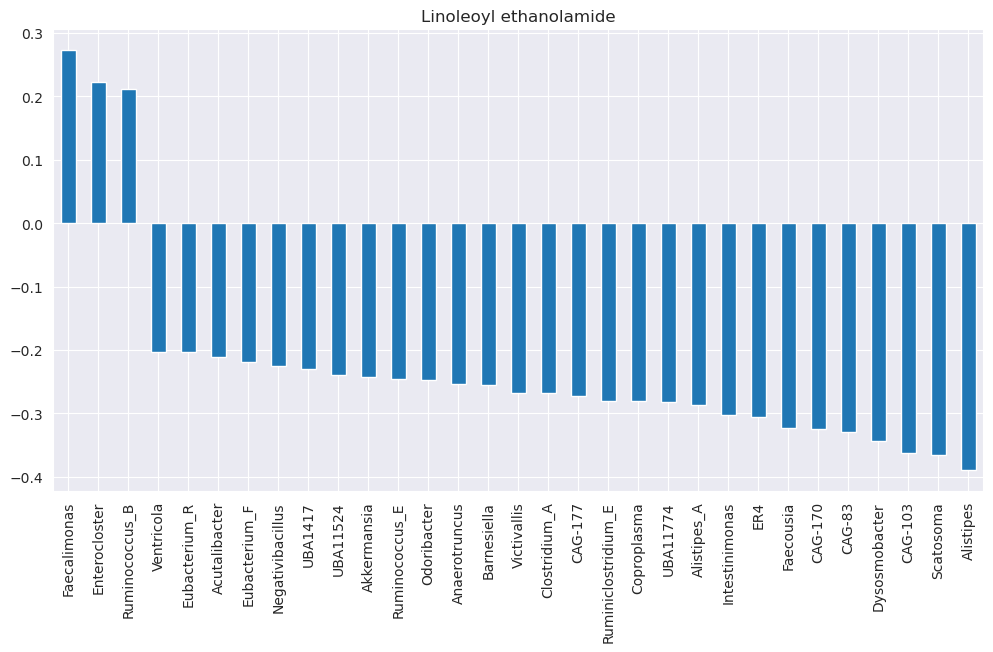

In [24]:
bottom_metabolite = metabolome_bacteria_significant_corr.sort_values(ascending=False).index[-1][0]
metabolome_bacteria_significant_corr.loc[idx[bottom_metabolite, :]].sort_values(ascending=False).plot.bar(figsize=(12,6), title=bottom_metabolite)

In [25]:
# How many bacteria are significantly correlated with metabolites?
print(f"We have {len(metabolome_bacteria_significant_corr.index.get_level_values(1).unique())} microbes with significant correlation to metabolite out of "
      f"{taxa.shape[1]} microbes ({round(len(metabolome_bacteria_significant_corr.index.get_level_values(1).unique()) / taxa.shape[1] * 100)}%)")

We have 104 microbes with significant correlation to metabolite out of 107 microbes (97%)


In [26]:
# Search for significant bacteria:
# Number of metabolites each bacteria significantly effects on
metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).sort_values(ascending=False)

Anaerotruncus              102
Faecalibacterium            90
Faecousia                   80
Clostridium_A               74
Ruthenibacterium            72
                          ... 
Phascolarctobacterium_A      1
UBA5026                      1
Merdimorpha                  1
Blautia_A                    1
CAG-41                       1
Length: 104, dtype: int64

In [27]:
metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).describe()

count    104.000000
mean      24.711538
std       22.624702
min        1.000000
25%        6.000000
50%       18.000000
75%       36.000000
max      102.000000
dtype: float64

In [28]:
# Number of bacteria each metabolites significantly effects on
metabolome_bacteria_significant_corr.groupby(axis=0, level=0).apply(lambda x: x.shape[0]).sort_values(ascending=False).describe()

count    325.000000
mean       7.907692
std        6.432755
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max       34.000000
dtype: float64

We can see that the #metabolites that correlate with the bacteria is highley divers (std 17) where most bacteria effect up to 4 metabolites, while some correlates with up to 86. 

In [29]:
# How many metabolism highly-derived from bacteria over-all the metabolites in the DB?
print(f"We have {len(metabolome_bacteria_significant_corr.index.get_level_values(0).unique())} metabolite with significant correlation to microbiome out of "
      f"{metabolite.shape[1]} metabolites ({round(len(metabolome_bacteria_significant_corr.index.get_level_values(0).unique()) / metabolite.shape[1] * 100)}%)")

We have 325 metabolite with significant correlation to microbiome out of 375 metabolites (87%)


Number of bacteria each metabolite have significant correlation with:

In [30]:
metabolome_bacteria_significant_corr.groupby(axis=0, level=0).apply(lambda x: x.shape[0]).sort_values(ascending=False).describe()


count    325.000000
mean       7.907692
std        6.432755
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max       34.000000
dtype: float64

we see most metabolites have 3-11 significantly associate (kendall-tau) bacteria.

<Axes: title={'center': 'Anaerotruncus significant correlation to metabolites'}>

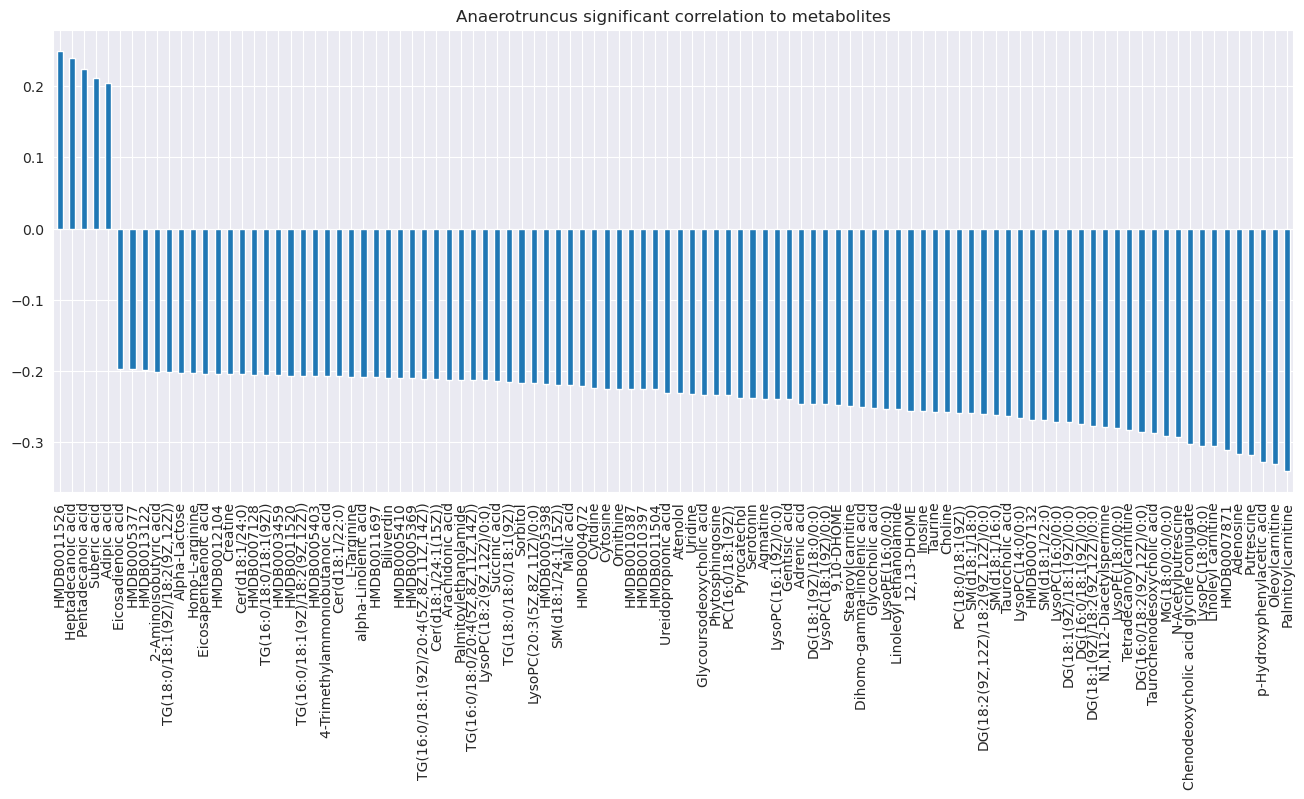

In [31]:
top_bacteria = metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).idxmax()
metabolome_bacteria_significant_corr.loc[idx[:, top_bacteria]].sort_values(ascending=False).plot.bar(figsize=(16,6), title=f'{top_bacteria} significant correlation to metabolites')


In [32]:
metabolites_feces_from_microbial_origin_hmdb = pd.read_csv('/home/noa/lab_code/H2Mtranslation/data/metabolites_feces_from_microbial_origin_hmdb')
metabolites_feces_from_microbial_origin_hmdb = metabolites_feces_from_microbial_origin_hmdb.set_index('HMDB_ID')['NAME']

Compare the overlap between the metabolites that we have find as significantly-correlated with microbiome and HMDB list of 117 feces metabolite that origin from microbial.

In [33]:
metabolome_bacteria_significant_corr.index.get_level_values(0).unique().intersection(metabolites_feces_from_microbial_origin_hmdb.unique())

Index(['p-Hydroxyphenylacetic acid', 'Butyric acid', 'Dimethylglycine',
       'Glycocholic acid', 'Indoleacetic acid', 'Phenylacetic acid',
       'Propionic acid', 'Succinic acid',
       'Chenodeoxycholic acid glycine conjugate',
       'Lithocholic acid glycine conjugate', 'Glycoursodeoxycholic acid',
       'Hydrocinnamic acid', 'Phenyllactic acid', 'Taurodeoxycholic acid',
       'Trimethylamine N-oxide', 'Taurochenodesoxycholic acid', 'Putrescine',
       'N-Acetylputrescine', 'Indole-3-propionic acid', 'Cadaverine',
       'Oxalic acid', 'D-Glutamic acid', 'Phenylacetylglutamine',
       '2-Hydroxyglutarate'],
      dtype='object')

In [34]:
metabolome_bacteria_significant_corr.index.get_level_values(0).unique().intersection(metabolites_feces_from_microbial_origin_hmdb.unique()).shape[0]

24

How many of the feces metabolite that origin from microbial (HMDB list) are in our datasets (with enough data?)

In [35]:
metabolite.columns.intersection(metabolites_feces_from_microbial_origin_hmdb.unique()).shape[0]

28

In [36]:
24/28

0.8571428571428571

In [37]:
metabolome_corr_df = pd.DataFrame({'#bacteria_in_assosiation': metabolome_bacteria_significant_corr.groupby(axis=0, level=0).apply(lambda x: x.shape[0]).sort_values(ascending=False), 'in_HMDB_list': pd.Series(metabolite.columns, index=metabolite.columns).apply(lambda x: x in metabolites_feces_from_microbial_origin_hmdb.unique())})
metabolome_corr_df = metabolome_corr_df.reset_index(drop=False).rename(columns={'index': 'metabolites'})


<Axes: xlabel='metabolites'>

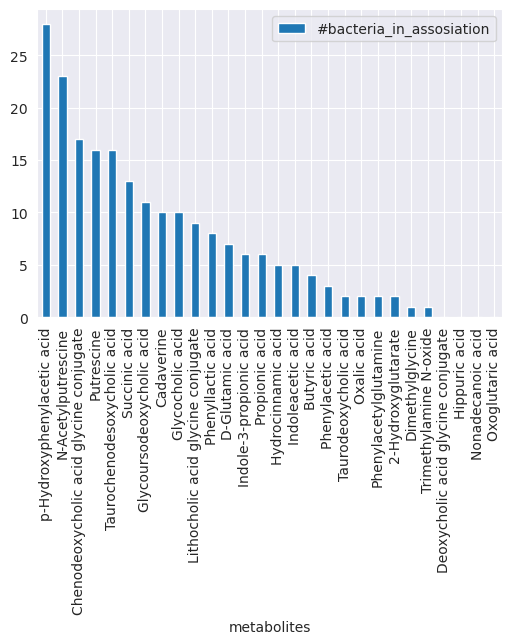

In [38]:
metabolome_corr_df[metabolome_corr_df['in_HMDB_list']].sort_values(by='#bacteria_in_assosiation', ascending=False).plot.bar(x='metabolites', y='#bacteria_in_assosiation',figsize=(6,4))

<Axes: xlabel='metabolites'>

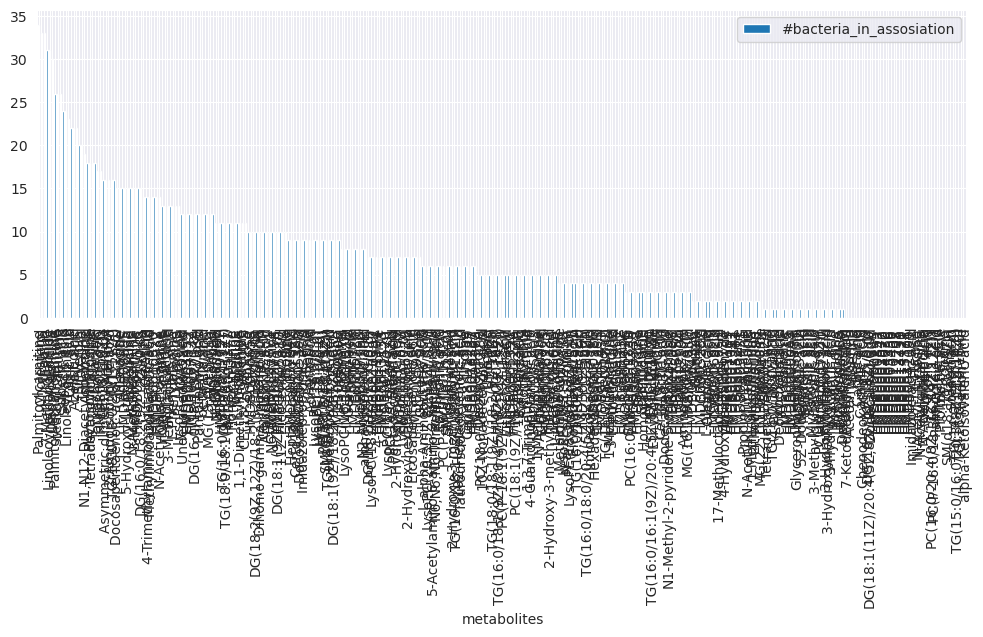

In [39]:
metabolome_corr_df[~metabolome_corr_df['in_HMDB_list']].sort_values(by='#bacteria_in_assosiation', ascending=False).plot.bar(x='metabolites', y='#bacteria_in_assosiation',figsize=(12,4))

What do we know on the 24 metabolites (fecal from microbial origin according to HMDB) #TODO

In [41]:
import re
taxa_genus = taxa.rename(columns=lambda x: re.match('.*g__(.*)', x).group(1))

In [42]:
metabolome_bacteria_p_values_fdr_correction = metabolome_bacteria_p_values_fdr_correction.rename(taxa_rename_to_genus.to_dict(), axis=0, level=1)

sanity checks - for some significant correlation between microbiome-metabolome plot the relation across the samples 
see how much I believe this correlation analysis & how much it's effected by outliers. 

<Axes: title={'center': 'corr coef=0.37, p-value=1.30e-04'}, xlabel='Faecalibacterium', ylabel='L-Alanine'>

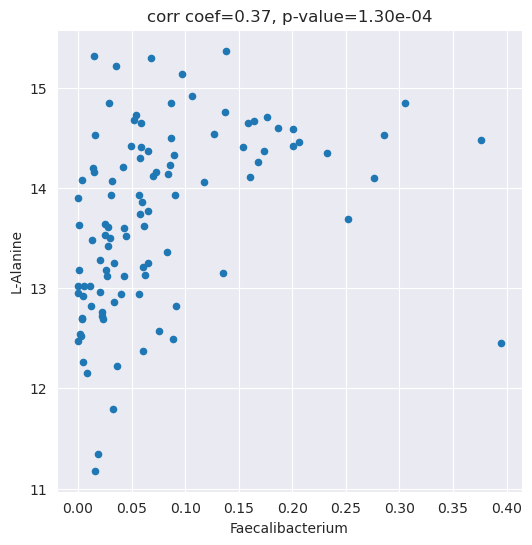

In [43]:
metabolite_1, microbiome_1 = metabolome_bacteria_significant_corr.sort_values(ascending=False).index[0]
pd.concat([metabolite[metabolite_1], taxa_genus[microbiome_1]], axis=1).plot.scatter(x=microbiome_1, y=metabolite_1, figsize=(6,6), 
                                                                                     title = f'corr coef={round(metabolome_bacteria_significant_corr[(metabolite_1, microbiome_1)],2)}, p-value={"{:.2e}".format(metabolome_bacteria_p_values_fdr_correction[(metabolite_1, microbiome_1)])}')

<Axes: title={'center': 'corr coef=0.36, p-value=2.22e-04'}, xlabel='Ventricola', ylabel='Urobilin'>

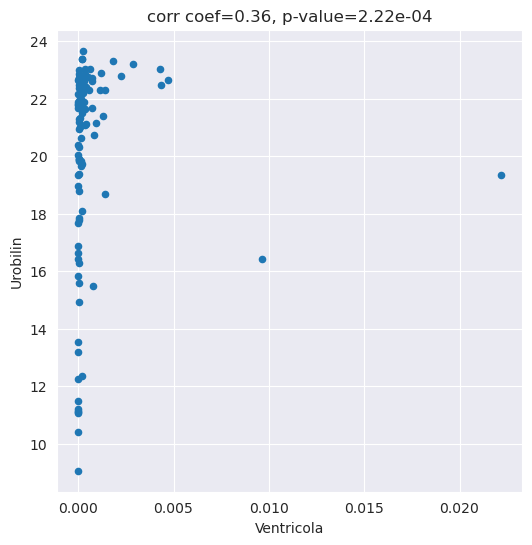

In [44]:
metabolite_1, microbiome_1 = metabolome_bacteria_significant_corr.sort_values(ascending=False).index[2]
pd.concat([metabolite[metabolite_1], taxa_genus[microbiome_1]], axis=1).plot.scatter(x=microbiome_1, y=metabolite_1, figsize=(6,6), 
                                                                                     title = f'corr coef={round(metabolome_bacteria_significant_corr[(metabolite_1, microbiome_1)],2)}, p-value={"{:.2e}".format(metabolome_bacteria_p_values_fdr_correction[(metabolite_1, microbiome_1)])}')

<Axes: title={'center': 'corr coef=0.36, p-value=2.22e-04'}, xlabel='Ventricola', ylabel='Urobilin'>

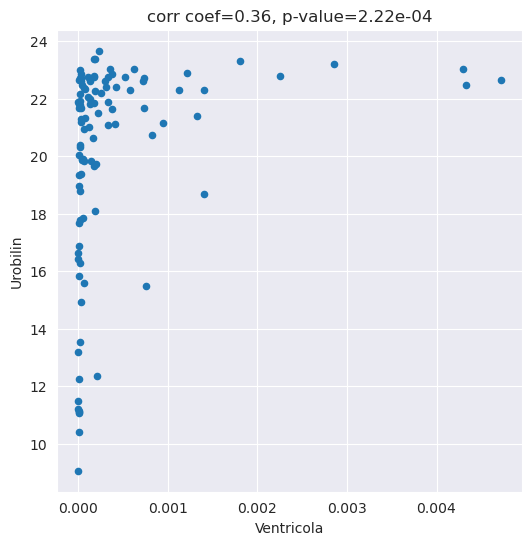

In [45]:
outliers = taxa_genus[microbiome_1][taxa_genus[microbiome_1] > 0.008].index
pd.concat([metabolite[metabolite_1].drop(outliers), taxa_genus[microbiome_1].drop(outliers)], axis=1).plot.scatter(x=microbiome_1, y=metabolite_1, figsize=(6,6), 
                                                                                     title = f'corr coef={round(metabolome_bacteria_significant_corr[(metabolite_1, microbiome_1)],2)}, p-value={"{:.2e}".format(metabolome_bacteria_p_values_fdr_correction[(metabolite_1, microbiome_1)])}')

In [46]:
# metabolome_bacteria_corr_coefficient 
# metabolome_bacteria_p_values_fdr_correction

In [47]:
#  For unknown (without a name, and known) taxa, plot a scatter plot of the correlations to see if it’s due to some outliers or do I believe it. (metabolite vs. taxa across the 90 samples + in the title mention the correlation coefficient) 

# Plot also metabolite vs. taxa across the 90 samples of metabolite that are known to be microbial origin (the 5 I didn't got as significant)? what does it even mean? read a bit more?

# The most interest question I think is why I didn't get the other 5 microbial origin metabolite as metabolite with correlation to microbiota?
metabolites_group = metabolite.columns.intersection(metabolites_feces_from_microbial_origin_hmdb.unique()).difference(metabolome_bacteria_significant_corr.index.get_level_values(0))
print(metabolites_group)

Index(['Deoxycholic acid glycine conjugate', 'Hippuric acid',
       'Nonadecanoic acid', 'Oxoglutaric acid'],
      dtype='object')


In [48]:
hmdb_metadata.query('name in @metabolites_group').set_index('name')['description'].iloc[0]

'Oxoglutaric acid, also known as alpha-ketoglutarate, alpha-ketoglutaric acid, AKG, or 2-oxoglutaric acid, is classified as a gamma-keto acid or a gamma-keto acid derivative. gamma-Keto acids are organic compounds containing an aldehyde substituted with a keto group on the C4 carbon atom. alpha-Ketoglutarate is considered to be soluble (in water) and acidic. alpha-Ketoglutarate is a key molecule in the TCA cycle, playing a fundamental role in determining the overall rate of this important metabolic process (PMID: 26759695). In the TCA cycle, AKG is decarboxylated to succinyl-CoA and carbon dioxide by AKG dehydrogenase, which functions as a key control point of the TCA cycle. Additionally, AKG can be generated from isocitrate by oxidative decarboxylation catalyzed by the enzyme known as isocitrate dehydrogenase (IDH). In addition to these routes of production, AKG can be produced from glutamate by oxidative deamination via glutamate dehydrogenase, and as a product of pyridoxal phosphate

Top 5 bacteria (that correlates with a lot of metabolites):  

In [49]:
metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).sort_values(ascending=False).iloc[:5].index.to_list()

['Anaerotruncus',
 'Faecalibacterium',
 'Faecousia',
 'Clostridium_A',
 'Ruthenibacterium']

Internet: 
Alistipes - Gram-negative genus in the phylum Bacteridota. Highly associated with our health. 
 https://en.wikipedia.org/wiki/Alistipes
 https://www.sciencedirect.com/topics/immunology-and-microbiology/alistipes
 https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2020.00906/full
 Indeed involve in a lot of pathways:
https://www.genome.jp/kegg-bin/show_organism?menu_type=pathway_maps&category=Alistipes


Our data: 
* per bacteria, show the relative-abundance across the 90 samples. (distribution)

[Text(0.5, 1.0, 'Heatmap significant or not correlation of Metabolite & Bacteria')]

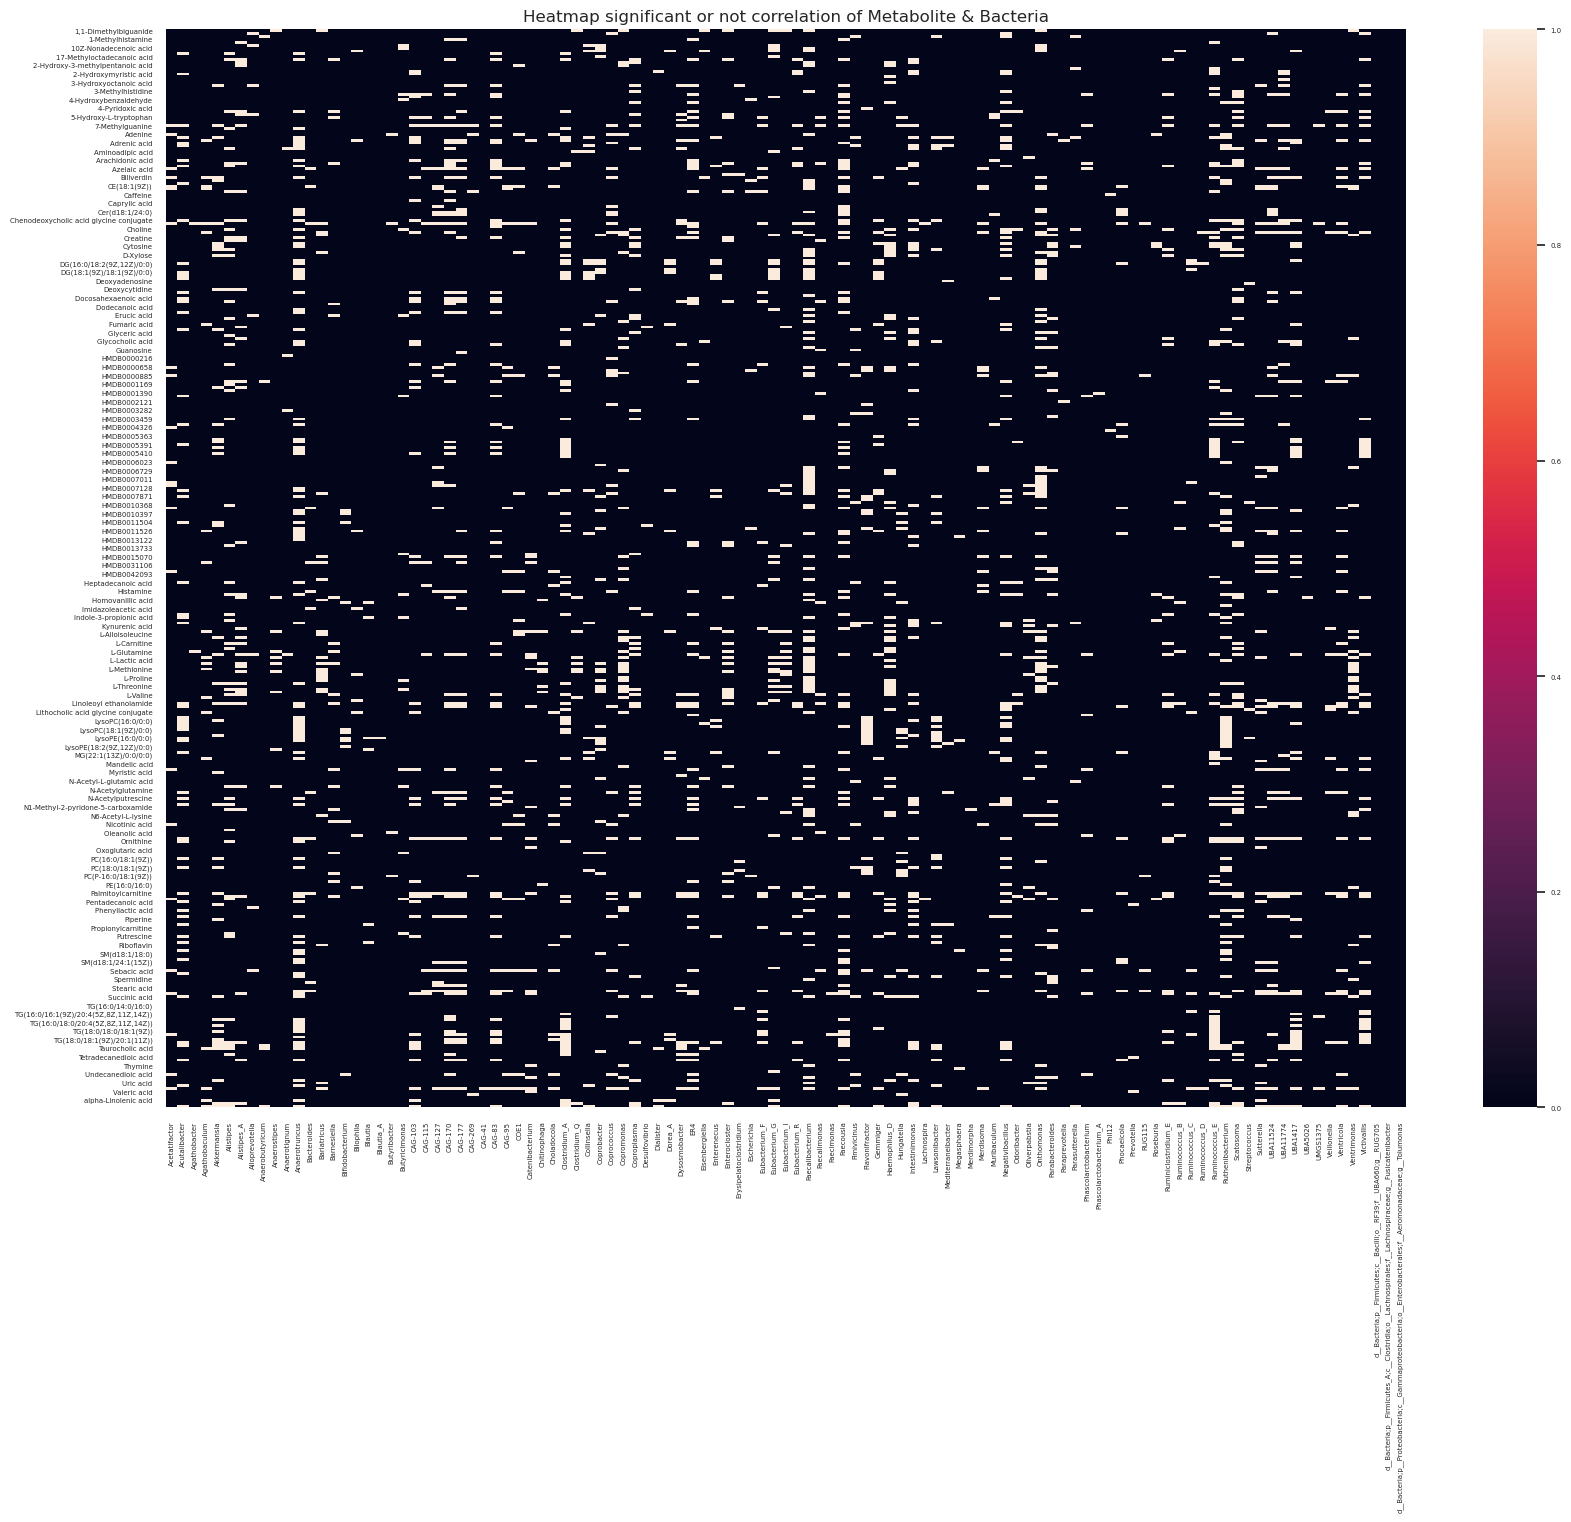

In [50]:
sns.set_theme(rc={'figure.figsize':(20,14), 'xtick.labelsize':5, 'ytick.labelsize':5})
sns.heatmap((metabolome_bacteria_p_values_fdr_correction.unstack() < 0.05).astype(int)).set(title='Heatmap significant or not correlation of Metabolite & Bacteria')

[Text(0.5, 1.0, 'Heatmap significant correlation of Metabolite & Bacteria')]

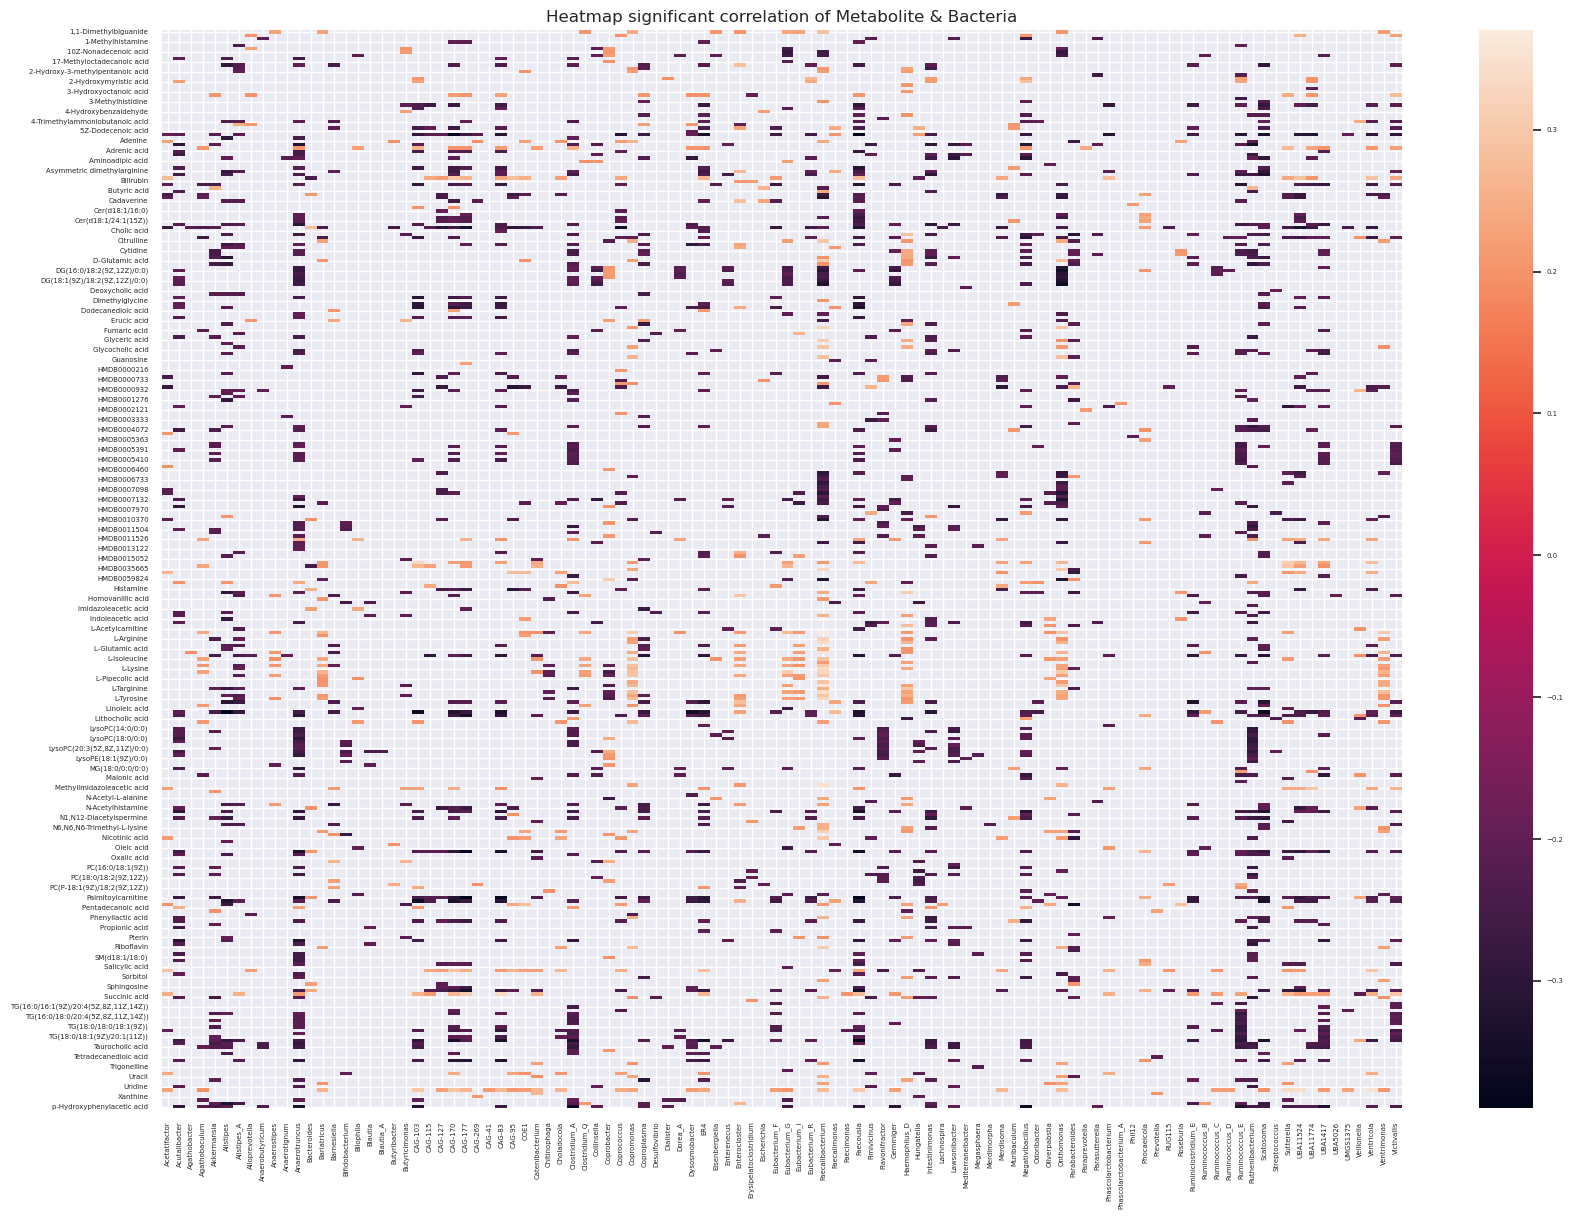

In [51]:
sns.heatmap(metabolome_bacteria_significant_corr.unstack().astype(float)).set(title='Heatmap significant correlation of Metabolite & Bacteria')
